**<font color=black size=5 face=雅黑>项目：员工留存</font>**

**<font color=black size=4 face=雅黑>1. 项目介绍</font>**

员工离职对于公司来说是一个代价高昂的问题。替换一名员工的成本通常是巨大的，考虑到面试和寻找替代者所花费的时间，安置费，签约奖金，几个月的生产力损失，以及当看到同事离开时对公司士气的影响。因此了解员工最有可能离职的原因和时间是非常有必要的，也有助于提高员工保留率或可以提前计划招聘新员工。

项目的主要目标是了解员工流失的主要原因。

数据集从几家公司的所有员工数据汇总得来（从2011年1月24日至2015年12月13日）。对于每个员工，我们也知道他们是否在2015年12月13日还在公司，或者他们已经辞职了。除此之外，我们还有员工的一些相关信息，比如他们任职期间的平均工资，部门和有几年的工作经验。

**<font color = black size=4 face=雅黑>2. 项目要解决的问题</font>**

1. 假设每个公司的员工人数从2011/01/23开始为零。请估计从2011年1月24日到2015年12月13日各公司每天的员工人数。举个例子，如果到2012/03/02时有2000人加入公司(id=1)，其中有1000人已经离职，那么公司(id=1)在2012/03/02的员工数为1000。请创建一个包含3列的表:day, employee_headcount, company_id



2. 导致员工流失的主要因素是什么?



3. 如果你能在这个数据集中添加一个变量来帮助解释员工流失，那会是什么呢?

**<font color=black size=4 face=雅黑>3. 项目用到的数据集</font>**

* employee_id:员工ID，员工id都是唯一的
* company：公司ID
* dept:员工所在部门
* seniority:被聘用时工作经验(几年）
* salary：员工在公司任职期间的平均年薪
* join_date;员工入职时间，只能在2011/01/24至2015/12/13之间
* quit_date:员工离职时间(如果截至2015年12月13日仍在职，此字段为NA)


**<font color = black size=4 face=雅黑>4. 第一题解答</font>**:

In [19]:
import pandas as pd
import numpy as np

#read from google drive
data=pd.read_csv('employee_retention.csv')

#转换成相同的date格式，便于后面join
data['join_date']=pd.to_datetime(data['join_date'])
data['quit_date']=pd.to_datetime(data['quit_date'])
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


**<font color = black size=3 face=雅黑>4.1 第一步：建立一个multipleindex(公司id,日期)</font>**：为了后续储存数据

In [20]:
#创建一个储存company_id的list
unique_company=data['company_id'].unique()

#创建一个储存日期的list
unqiue_date=pd.date_range(start='2011/01/24', end='2015/12/13',freq='D')

#创建 MultiIndex多层次索引
data_hc=pd.MultiIndex.from_product([unqiue_date,unique_company],names=['date','company_id'])

#以index=data_hc创建dataframe
data_hc= pd.DataFrame(index=data_hc)

#将index转换成column
data_hc=data_hc.reset_index()

**<font color = black size=3 face=雅黑>4.2 第二步：得到每个公司每天新增多少员工</font>**

In [21]:
data_join=pd.DataFrame(data.groupby(['join_date','company_id']).size())

#rename_axis(index={'join_date': 'date'})--将multipleindex中其中的一个index（join_date）改名为date，为了方便后面数据合并
#rename(columns={0: 'join_count'})--将得到的数值column改名为join_count,方便理解
data_join=data_join.rename_axis(index={'join_date': 'date'}).rename(columns={0: 'join_count'})

#方法二：data_join=pd.DataFrame(data.groupby(['join_date','company_id']).size().reset_index(name='join_count')
#data_join.columns.values[0]='date'或者 data_join.rename(columns={'join_date':'date'})

**<font color = black size=3 face=雅黑>4.3 第三步：得到每个公司每天有多少员工离职</font>**

In [22]:
data_quit=pd.DataFrame(data.groupby(['quit_date','company_id']).size())

#rename_axis(index={'quit_date': 'date'})--将multipleindex中其中的一个index（quit_date）改名为date，为了方便后面数据合并
#rename(columns={0: 'quit_count'})--将得到的数值column改名为quit_count,方便理解
data_quit=data_quit.rename_axis(index={'quit_date': 'date'}).rename(columns={0: 'quit_count'})

**<font color = black size=3 face=雅黑>4.4 第四步：将每天新增的员工-每天离职的员工</font>**

In [23]:
#将data_join的数据储存到data_hc里
data_hc=pd.merge(data_hc,data_join,on=['date','company_id'],how='left')

#将data_quit的数据储存到data_hc里
data_hc=pd.merge(data_hc,data_quit,on=['date','company_id'],how='left')

#将空值NA用0填充
data_hc.fillna('0',inplace=True)

#转换join_count和quit_count的数据类型为int
data_hc[['join_count','quit_count']]=data_hc[['join_count','quit_count']].astype('int')

#将每天新增的员工join_count-每天离职的员工quit_count
data_hc['headcounts']=data_hc['join_count']-data_hc['quit_count']


**<font color = black size=3 face=雅黑>4.5 第五步：将公司把每天的headcounts累加得到最终表格</font>**

In [24]:
#按照公司把每天的headcounts累加起来
data_hc['count'] = data_hc.groupby(['company_id'])['headcounts'].apply(lambda x: x.cumsum())

#创建一个包含3列的表:day, employee_headcount, company_id
data_hc_table=data_hc[['date','company_id','count']]

#检查一下company_id=1
data_hc_table[data_hc_table['company_id']==1]

,date,company_id,count
4,2011-01-24,1,25
16,2011-01-25,1,27
28,2011-01-26,1,29
40,2011-01-27,1,29
52,2011-01-28,1,29
...,...,...,...
21364,2015-12-09,1,3864
21376,2015-12-10,1,3865
21388,2015-12-11,1,3865
21400,2015-12-12,1,3865


**<font color = black size=4 face=雅黑>5. 第二题解答：导致员工流失的主要因素是什么</font>**

**<font color = black size=3 face=雅黑>5.1 查看离职者从入职到离职的工作时长</font>**

In [25]:
data.head()

,employee_id,company_id,dept,seniority,salary,join_date,quit_date
0,13021.0,7,customer_service,28,89000.0,2014-03-24,2015-10-30
1,825355.0,7,marketing,20,183000.0,2013-04-29,2014-04-04
2,927315.0,4,marketing,14,101000.0,2014-10-13,NaT
3,662910.0,7,customer_service,20,115000.0,2012-05-14,2013-06-07
4,256971.0,2,data_science,23,276000.0,2011-10-17,2014-08-22


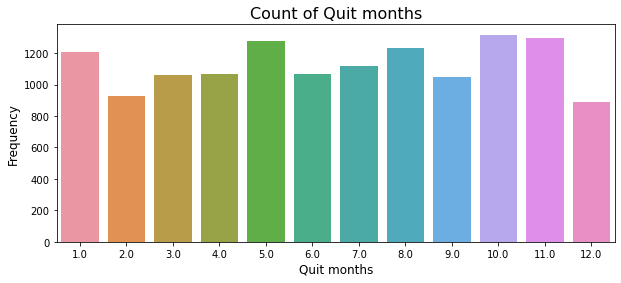

In [27]:
#查看员工哪个月离职人数最多
import seaborn as sns
month = np.array(list(map(lambda x: x.month, data['quit_date'] )))

fig, ax = plt.subplots(figsize=(10, 4))
sns.countplot(month, ax=ax)
ax.set_title('Count of Quit months', fontsize=16)
ax.set_xlabel('Quit months', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

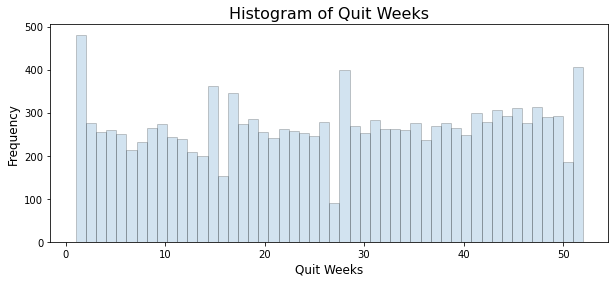

In [28]:
#查看员工哪周离职人数最多

weeks = np.array(list(map(lambda x: x.week, data['quit_date'] )))

hist_kws={'histtype': 'bar', 'edgecolor':'black', 'alpha': 0.2}
fig, ax = plt.subplots(figsize=(10, 4))
sns.distplot(weeks , bins=50, kde=False, ax=ax, hist_kws=hist_kws)
ax.set_title('Histogram of Quit Weeks', fontsize=16)
ax.set_xlabel('Quit Weeks', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
plt.show()

In [29]:
#创建一个新的feature：quit_length工作多少时间离职

data['employment_length'] = (data['quit_date'] - data['join_date']).astype('timedelta64[D]')

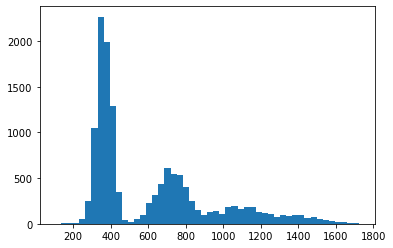

In [30]:
import matplotlib.pyplot as plt

#去掉没有离职的人画图
plt.hist(data['employment_length'].dropna(),bins=50) #bins参数的含义是所画出的直方图的“柱”的个数；每个“柱”的值为其跨越的值的个数和
plt.show()

通过查看离职者从入职到离职的工作时长，可以看出很大一部分离职者都是在工作一年左右离职，为了找到大部分员工离职的主要原因，将员工分为工作13个月离职以及其他

**<font color = black size=3 face=雅黑>5.2 将员工分为工作13个月离职以及其他 </font>**

In [31]:
#将入职时间在2014-11-12之后的员工去除
from datetime import timedelta

data=data[data['join_date']<pd.to_datetime("2015/12/13") - timedelta(days=(365+31))] 

#员工工作时长<396标记为1（是需要分析的大部分离职者）
#员工工作时长>396或者未离职的标记为0
data['early_quitter'] = np.where((data['employment_length']>396) | (np.isnan(data['employment_length'])), 0, 1)

**<font color = black size=3 face=雅黑>5.3 建模 </font>**

不需要去预测员工什么时候离开而是要找出员工离职的主要原因，使用随机森林和决策树模型（因为有好的解释行）

In [32]:
#get_dummies函数将数据转换成one-hot编码 默认drop_first=False,当drop_first=True时删除冗杂的列

data_dummy = pd.get_dummies(data[['company_id', 'dept', 'seniority', 'salary', 'early_quitter']])
data_dummy.head()

,company_id,seniority,salary,early_quitter,dept_customer_service,dept_data_science,dept_design,dept_engineer,dept_marketing,dept_sales
0,7,28,89000.0,0,1,0,0,0,0,0
1,7,20,183000.0,1,0,0,0,0,1,0
2,4,14,101000.0,0,0,0,0,0,1,0
3,7,20,115000.0,1,1,0,0,0,0,0
4,2,23,276000.0,0,0,1,0,0,0,0


In [33]:
#将数据集分为有label的和无lable的

X=data_dummy.iloc[:,data_dummy.columns !='early_quitter']
Y=data_dummy.iloc[:,data_dummy.columns =='early_quitter']

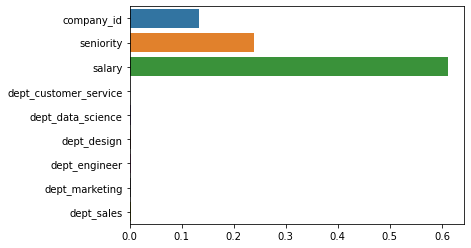

In [36]:
#随机森林
import warnings
warnings.filterwarnings("ignore")
from sklearn.ensemble import RandomForestClassifier

rf0 = RandomForestClassifier(oob_score=True, random_state=10)
rf0.fit(X,Y)

#特征重要性
feature_importances = pd.Series(rf0.feature_importances_, 
              index=X.columns)
sns.barplot(y=feature_importances.index,x=feature_importances.values)

In [37]:
#决策树
import graphviz
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from graphviz import Source
  
tree = DecisionTreeClassifier(max_depth=4, min_samples_leaf = 30, class_weight="balanced", min_impurity_decrease = 0.001)
tree.fit(data_dummy.drop('early_quitter', axis=1), data['early_quitter'])
  
#visualize it
export_graphviz(tree, out_file="tree_employee.dot", feature_names=data_dummy.drop('early_quitter', axis=1).columns, proportion=True, rotate=True)
with open("tree_employee.dot") as f:
    dot_graph = f.read()
s = Source.from_file("tree_employee.dot")
s.view()

'tree_employee.dot.pdf'

从随机森林还有决策树的结果可以看出，工资是最重要的。毕竟，它可能也包含了其他变量的信息。也就是说，资历、部门和公司会影响工资。所以工资包含了所有可用的信息。

并且工资在224500到62500之间，员工成为早期辞职者的可能性更高。赚很多钱却赚得很少的人都不太可能放弃，赚很多可以理解，赚很少可能是因为能力本身不足所以也找不到更高工资的工作。

**<font color = black size=4 face=雅黑>5. 第三题解答：如果你能在这个数据集中添加一个变量来帮助解释员工流失，那会是什么呢?</font>**

因为薪水很重要，我希望添加一个变量是：辞职的员工在下一份工作的薪水或者员工任期期间内获得的晋升或加薪